# PySpark PyTorch Inference

### Image Classification
Based on: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

In [1]:
import torch

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
torch.__version__

'1.10.2+cpu'

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [5]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {X.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28]) torch.float32
Shape of y: torch.Size([64]) torch.int64


### Create model

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Train Model

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302941  [    0/60000]
loss: 2.295642  [ 6400/60000]
loss: 2.276620  [12800/60000]
loss: 2.272733  [19200/60000]
loss: 2.252102  [25600/60000]
loss: 2.214275  [32000/60000]
loss: 2.221409  [38400/60000]
loss: 2.181246  [44800/60000]
loss: 2.187984  [51200/60000]
loss: 2.148991  [57600/60000]
Test Error: 
 Accuracy: 51.9%, Avg loss: 2.149225 

Epoch 2
-------------------------------
loss: 2.160908  [    0/60000]
loss: 2.154399  [ 6400/60000]
loss: 2.089876  [12800/60000]
loss: 2.106685  [19200/60000]
loss: 2.060231  [25600/60000]
loss: 1.987645  [32000/60000]
loss: 2.017416  [38400/60000]
loss: 1.929185  [44800/60000]
loss: 1.943034  [51200/60000]
loss: 1.857908  [57600/60000]
Test Error: 
 Accuracy: 57.6%, Avg loss: 1.863937 

Epoch 3
-------------------------------
loss: 1.900003  [    0/60000]
loss: 1.872490  [ 6400/60000]
loss: 1.741499  [12800/60000]
loss: 1.785799  [19200/60000]
loss: 1.692519  [25600/60000]
loss: 1.624967  [32000/600

### Save Model State Dict
This is the [currently recommended save format](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference).

In [11]:
torch.save(model.state_dict(), "model_weights.pt")
print("Saved PyTorch Model State to model_weights.pt")

Saved PyTorch Model State to model_weights.pt


### Save Entire Model
This saves the entire model using python pickle, but has the [following disadvantage](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-entire-model):
> The serialized data is bound to the specific classes and the exact directory structure used when the model is saved... Because of this, your code can break in various ways when used in other projects or after refactors.

In [12]:
torch.save(model, "model.pt")

### Save Model as TorchScript
This saves an [intermediate representation of the compute graph](https://pytorch.org/tutorials/beginner/saving_loading_models.html#export-load-model-in-torchscript-format), which does not require pickle (or even python).  However, this currently doesn't work with spark, which uses pickle serialization.

In [13]:
scripted = torch.jit.script(model)

In [14]:
scripted.save("model.ts")

### Load Model State

In [15]:
model_from_state = NeuralNetwork()
model_from_state.load_state_dict(torch.load("model_weights.pt"))

<All keys matched successfully>

In [16]:
model_from_state.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model_from_state(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


### Load Model

In [17]:
new_model = torch.load("model.pt")

In [18]:
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = new_model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


### Load Torchscript Model

In [19]:
ts_model = torch.jit.load("model.ts")

In [20]:
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = ts_model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


## PySpark

In [21]:
import pandas as pd
from pyspark.sql.types import StructType, StructField, ArrayType, FloatType

### Convert numpy array to Spark DataFrame (via Pandas DataFrame)

In [22]:
data = test_data.data.numpy()
data.shape, data.dtype

((10000, 28, 28), dtype('uint8'))

In [23]:
data = data.reshape(10000, 784) / 255.0
data.shape, data.dtype

((10000, 784), dtype('float64'))

In [24]:
test_pdf = pd.DataFrame(data)

In [25]:
%%time
# 1 column of array<float>
test_pdf['data'] = test_pdf.values.tolist()
pdf = test_pdf[['data']]
pdf.shape

CPU times: user 165 ms, sys: 83.9 ms, total: 249 ms
Wall time: 247 ms


(10000, 1)

In [26]:
%%time
# force FloatType since Pandas uses double
schema = StructType([StructField("data",ArrayType(FloatType()), True)])
df = spark.createDataFrame(pdf, schema)

CPU times: user 3.72 s, sys: 48 ms, total: 3.77 s
Wall time: 5.67 s


In [27]:
df.schema

StructType(List(StructField(data,ArrayType(FloatType,true),true)))

### Save the test dataset as parquet files

In [28]:
%%time
df.write.mode("overwrite").parquet("fashion_mnist_test")

22/02/24 14:37:35 WARN TaskSetManager: Stage 0 contains a task of very large size (4315 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 7.86 ms, sys: 3.89 ms, total: 11.7 ms
Wall time: 4.23 s


### Check arrow memory configuration

In [29]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "512")
# This line will fail if the vectorized reader runs out of memory
assert len(df.head()) > 0, "`df` should not be empty"

22/02/24 14:37:39 WARN TaskSetManager: Stage 1 contains a task of very large size (4315 KiB). The maximum recommended task size is 1000 KiB.


## Inference using Spark ML Model
Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import sparkext
import torch
from torch import nn

In [31]:
df = spark.read.parquet("fashion_mnist_test")

### Define Model
Since the model is pickled, the class must be defined before reloading.

In [32]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [33]:
model = sparkext.torch.Model("model.pt").setInputShape((-1,28,28))

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [34]:
predictions = model.transform(df)

/home/leey/devpub/spark/python/pyspark/sql/pandas/functions.py:389: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [35]:
predictions.write.mode("overwrite").parquet("mnist_predictions")

In [36]:
predictions.take(1)

[Row(prediction=[0.9647578597068787, -2.5204579830169678, 2.269679546356201, -0.6357944011688232, 2.277003765106201, -1.2671245336532593, 2.139357089996338, -3.0041282176971436, 1.4756426811218262, -1.3084547519683838])]

In [37]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [38]:
img = np.array(df.take(1)[0].data)

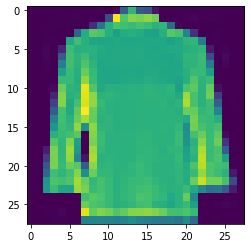

In [39]:
plt.figure()
plt.imshow(img.reshape(28,28))
plt.show()